### Portfolio Testing (pricing)

In [1]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd

%load_ext autoreload
%autoreload 2

In [2]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])


data = HistoricalData(env_df, features_df, targets_df)

In [3]:
import instrument

date = Timestamp('2018-12-31')


opt_buy = date + MonthEnd(2)
env_now = Environment(*data.get_env_args(date))
pos_dict = {}
etf_dict = {}


icash = instrument.Cash('USD')
for etf in env_df[['EQ', 'FI', 'EM', 'RE']].columns.droplevel():
    etf_dict[etf] = instrument.Equity(etf, 'USD')
    pos_dict[etf_dict[etf]] = 200000/27/env_now.prices[etf]

iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_buy)

icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_buy)




pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5


pos_dict[icash] = -(pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))

In [4]:
# option price
icall.value(env_now)

4.213865086912866

In [5]:
from portfolio import Portfolio
my_pf = Portfolio(pos_dict)
my_pf.calc_value(env_now)

200000.00000000003

### Regression Testing (mapping shocks to assets)

In [6]:
from historical import ShockMap, Distribution
sm = ShockMap(data, date)

In [7]:
# Runtime: 18s on Ethan's Macbook
dist = Distribution(data, date, method='student')
N = 1000
rets = []
val_now = my_pf.calc_value(env_now)
factor_shocks = dist.generate_shock(N)
for i in range(N):
    asset_shocks = sm.map_factors(factor_shocks.iloc[i])
    env_sim = env_now.simulate(asset_shocks)
    #print(my_pf.calc_value(env_sim))
    #print(i1.value(env_sim), i2.value(env_sim))
    ret = np.log(my_pf.calc_value(env_sim)/val_now)
    rets.append(ret)
    
rets = pd.Series(rets)

In [8]:
import matplotlib.pyplot as plt
rets.hist(bins=20)
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
# Runtime: 18s on Ethan's Macbook
dist = Distribution(data, date, method='normal')
N = 1000
rets = []
val_now = my_pf.calc_value(env_now)
factor_shocks = dist.generate_shock(N)
for i in range(N):
    asset_shocks = sm.map_factors(factor_shocks.iloc[i])
    env_sim = env_now.simulate(asset_shocks)
    #print(my_pf.calc_value(env_sim))
    #print(i1.value(env_sim), i2.value(env_sim))
    ret = np.log(my_pf.calc_value(env_sim)/val_now)
    rets.append(ret)
    
rets = pd.Series(rets)

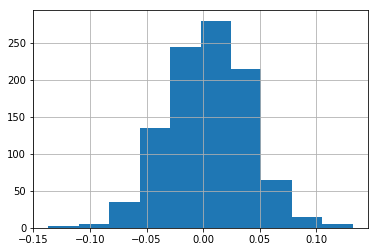

In [10]:
import matplotlib.pyplot as plt
rets.hist(bins=10)
plt.show()

### Testing portfolio performance

In [11]:
pf_val = 200000
date = Timestamp('2014-06-01') + MonthEnd(0)
opt_mat = date + MonthEnd(2)
env_now = Environment(*data.get_env_args(date))
pos_dict = {}
etf_dict = {}

icash = instrument.Cash('USD')
for etf in env_df[['EQ', 'FI', 'EM', 'RE']].columns.droplevel():
    etf_dict[etf] = instrument.Equity(etf, 'USD')
    pos_dict[etf_dict[etf]] = pf_val/27/env_now.prices[etf]

iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_mat)

icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                       K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_mat)

pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5
pos_dict[icash] = -(pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))
my_pf = Portfolio(pos_dict)

In [12]:
pf_vals = []

for i in range(1, 60):
    # set date to nex month
    date = Timestamp('2014-06-01') + MonthEnd(i)
    opt_mat = date + MonthEnd(2)
    env_now = Environment(*data.get_env_args(date))
    

    # sell current options
    opt_val = pos_dict[iput] * iput.value(env_now) + pos_dict[icall] * icall.value(env_now)
    my_pf.pf_units[iput] = 0
    my_pf.pf_units[icall] = 0
    del pos_dict[iput], pos_dict[icall]
    
    # add cash from sold options
    my_pf.pf_units[icash] = my_pf.pf_units[icash] + opt_val
    
    # buy new options
    iput = instrument.Option(name='SPY Put', ccy='USD', is_call=0, ul='SPY US Equity',
                           K=etf_dict['SPY US Equity'].value(env_now)*0.9, T=opt_mat)

    icall = instrument.Option(name='SPY Call', ccy='USD', is_call=1, ul='SPY US Equity',
                           K=etf_dict['SPY US Equity'].value(env_now)*1.1, T=opt_mat)
    
    
    pos_dict[iput] = pos_dict[etf_dict['SPY US Equity']] * 5
    pos_dict[icall] = pos_dict[etf_dict['SPY US Equity']] * 5
    pos_dict[icash] = pos_dict[icash] - (pos_dict[iput]*iput.value(env_now) + pos_dict[icall]*icall.value(env_now))
    
    # record portf val
    pf_vals.append(my_pf.calc_value(env_now))

In [13]:
pf_vals = np.array(pf_vals)
pf_rets = pf_vals[1:]/pf_vals[0:-1] - 1

In [14]:
m = pf_rets.mean()*12
s = pf_rets.std()*np.sqrt(12)
print(m,s)
print(m/s)

0.05831585774853454 0.08534665960589881
0.6832822516758932


In [15]:
var = np.percentile(pf_rets, 5)*my_pf.calc_value(env_now)
cvar = pf_rets[pf_rets<=np.percentile(pf_rets, 5)].mean()*my_pf.calc_value(env_now)
print(-var, -cvar)

12024.031844906332 13719.778867905483


In [16]:
my_pf.get_options()

[<instrument.Option at 0x2453cb1b7b8>, <instrument.Option at 0x2453930e5c0>]

In [17]:
list(my_pf.pf_units.keys())[-1].T

Timestamp('2019-06-30 00:00:00')

In [18]:
my_pf.sell_options(env_now)

In [19]:
my_pf.calc_value(env_now)

260332.97469543805

In [20]:
specs = [{'name':'SPY Call 1', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity','K':my_pf.get_asset('SPY US Equity').value(env_now)},
         {'name':'SPY Call 2', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity','K':my_pf.get_asset('SPY US Equity').value(env_now)*1.05}
         ]
my_pf.buy_options(env_now, specs, [50, -50])


In [21]:
my_pf.calc_value(env_now)

260332.97469543805

In [22]:
my_pf.pf_units

[autoreload of instrument failed: Traceback (most recent call last):
  File "c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\IPython\extensions\autoreload.py", line 331, in update_generic
    update(a, b)
  File "c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\IPython\extensions\autoreload.py", line 289, in update_class
    if update_generic(old_obj, new_obj): continue
  File "c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\IPython\extensions\autoreload.py", line 331, in update_generic
    update(a, b)
  File "c:\users\vladislav\appdata\local\pro

{<instrument.Equity at 0x2453cbcc8d0>: 30.6516665380063,
 <instrument.Equity at 0x2453cbcccc0>: 81.46014706896412,
 <instrument.Equity at 0x2453cbcc978>: 320.0684178249943,
 <instrument.Equity at 0x2453cbcccf8>: 167.22255624927834,
 <instrument.Equity at 0x2453cbccd30>: 101.8166741909189,
 <instrument.Equity at 0x2453cbccd68>: 128.56868087504873,
 <instrument.Equity at 0x2453cbccda0>: 62.773468693019346,
 <instrument.Equity at 0x2453cbccdd8>: 135.5923010691453,
 <instrument.Equity at 0x2453cbcce10>: 113.89037800558133,
 <instrument.Equity at 0x2453cbcce48>: 111.48782848355705,
 <instrument.Equity at 0x2453cbccbe0>: 128.83164641175523,
 <instrument.Equity at 0x2453cbcce80>: 116.70961288646858,
 <instrument.Equity at 0x2453cbcceb8>: 76.81665925962031,
 <instrument.Equity at 0x2453cbccef0>: 179.82243074431292,
 <instrument.Equity at 0x2453cbccf28>: 112.384483501424,
 <instrument.Equity at 0x2453cbccf60>: 43.57598380245821,
 <instrument.Equity at 0x2453cbccf98>: 45.93271018722058,
 <instru

In [23]:
Portfolio.weights_to_pos({'SPY US Equity': 0.4, 'XLU US Equity': 0.6}, env_now, 100000)

{'SPY US Equity': 100.24002473923811, 'XLU US Equity': 591.5625434428742}

In [24]:
env_now.prices

{'SPY US Equity': 399.0422,
 'EFA US Equity': 100.4163,
 'XLF US Equity': 38.3799,
 'XLK US Equity': 98.40100000000001,
 'XLV US Equity': 114.704,
 'XLP US Equity': 84.5084,
 'XLE US Equity': 89.3335,
 'EWJ US Equity': 67.18,
 'EWZ US Equity': 62.9673,
 'XLU US Equity': 101.4263,
 'XLI US Equity': 105.7064,
 'EZU US Equity': 61.3173,
 'IYR US Equity': 164.18099999999995,
 'XLB US Equity': 80.75,
 'RWR US Equity': 179.9543,
 'IXN US Equity': 205.7194,
 'ISMUF US Equity': 4.5286,
 'ICF US Equity': 196.2644,
 'IYZ US Equity': 46.1624,
 'ILF US Equity': 47.2365,
 'IEV US Equity': 68.7014,
 'TIP US Equity': 179.6958,
 'AGG US Equity': 180.5315,
 'IEF US Equity': 164.5138,
 'TLT US Equity': 212.1756,
 'SHY US Equity': 109.7469,
 'LQD US Equity': 230.10307999999998}